In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

import warnings
warnings.filterwarnings('ignore')

# Source Code 1.1)

- AMZM (Amazon.com) - (Jan 01, 2013 - Jan 01, 2022) Monthly Dataset

### Utilization Function

In [2]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [3]:
def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    
    print('Results of Dickey_Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
        
    print(dfoutput)

### Load Data

In [4]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/AMZN.csv'

df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2003-01-01    21.850000
2003-02-01    22.010000
2003-03-01    26.030001
2003-04-01    28.690001
2003-05-01    35.889999
Name: Close, dtype: float64

### Data Preprocessing

In [5]:
ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [6]:
ts_log = np.log(ts)

### Stationary Analysis

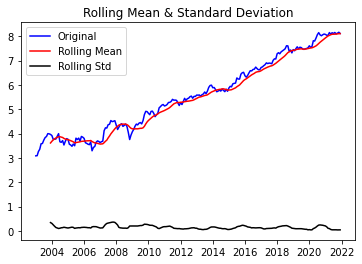

In [7]:
plot_rolling_statistics(ts_log)

In [8]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey_Fuller Test:
Test Statistic                  -0.374986
p-value                          0.914192
#Lags Used                       0.000000
Number of Observations Used    227.000000
Critical Value (1%)             -3.459490
Critical Value (5%)             -2.874358
Critical Value (10%)            -2.573602
dtype: float64


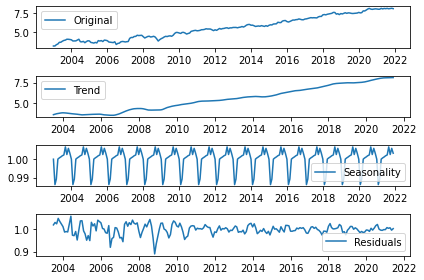

In [9]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

In [10]:
residual.dropna(inplace=True)

augmented_dickey_fuller_test(residual)

Results of Dickey_Fuller Test:
Test Statistic                -6.481833e+00
p-value                        1.289304e-08
#Lags Used                     1.500000e+01
Number of Observations Used    2.000000e+02
Critical Value (1%)           -3.463476e+00
Critical Value (5%)           -2.876102e+00
Critical Value (10%)          -2.574532e+00
dtype: float64


### Separate Dataset

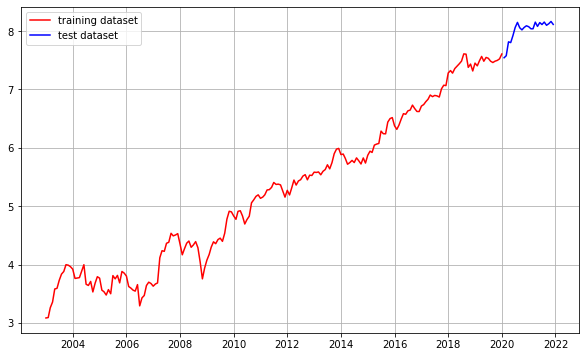

In [11]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### Set ARIMA Parameters

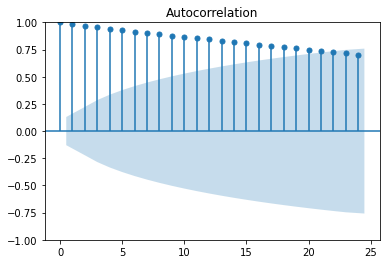

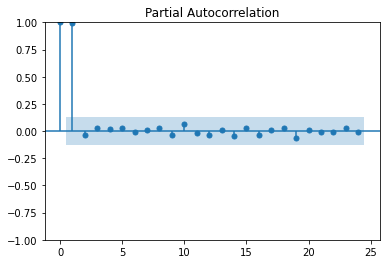

In [12]:
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

- `ACF` 는 점차적으로 감소하고 있고, `PACF` 는 `p` 가 2 이상일 때 0 에 가까워지고 있습니다.
- 따라서, `p` 를 1 로 설정하도록 하겠습니다.

Results of Dickey_Fuller Test:
Test Statistic                -1.489608e+01
p-value                        1.531647e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.260000e+02
Critical Value (1%)           -3.459620e+00
Critical Value (5%)           -2.874415e+00
Critical Value (10%)          -2.573632e+00
dtype: float64
Results of Dickey_Fuller Test:
Test Statistic                -8.183099e+00
p-value                        8.032470e-13
#Lags Used                     9.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


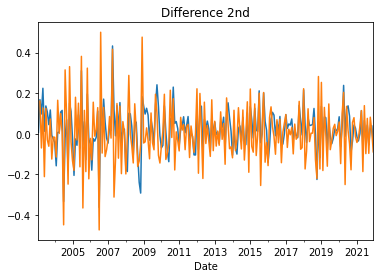

In [13]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

- 1차 차분 후의 그래프도 안정성을 보이고 있습니다.

### Training & Forecasting

In [14]:
model = ARIMA(train_data, order=(1, 1, 0))
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  205
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 166.637
Date:                Mon, 14 Feb 2022   AIC                           -329.273
Time:                        03:14:16   BIC                           -322.637
Sample:                    01-01-2003   HQIC                          -326.589
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0528      0.066      0.796      0.426      -0.077       0.183
sigma2         0.0114      0.001     13.719      0.000       0.010       0.013
Ljung-Box (L1) (Q):                   0.36   Jarque-

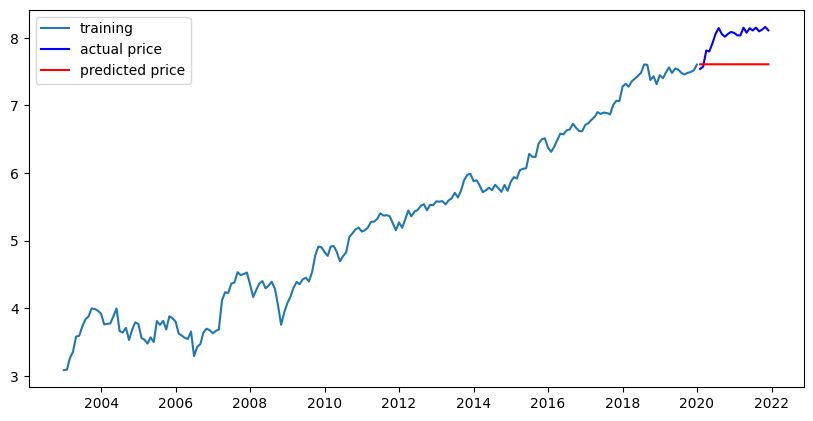

In [15]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

In [16]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1304891.4150093882
MAE:  1067.1368212734453
RMSE:  1142.3184385316506
MAPE: 33.21%


- 그래프의 변동성이 커 올바르게 예측하지 못했음을 알 수 있습니다.

In [17]:
model = ARIMA(train_data, order=(4, 2, 0))
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  205
Model:                 ARIMA(4, 2, 0)   Log Likelihood                 150.324
Date:                Mon, 14 Feb 2022   AIC                           -290.648
Time:                        03:15:09   BIC                           -274.082
Sample:                    01-01-2003   HQIC                          -283.946
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7640      0.064    -11.981      0.000      -0.889      -0.639
ar.L2         -0.5419      0.074     -7.316      0.000      -0.687      -0.397
ar.L3         -0.4175      0.073     -5.744      0.0

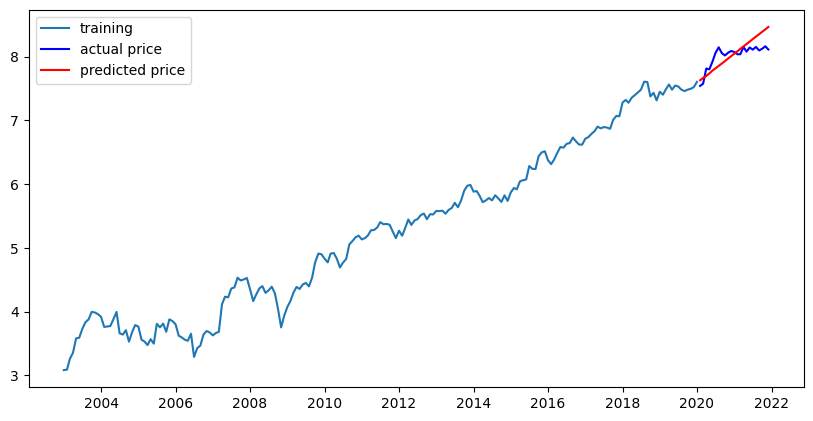

In [18]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

In [19]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  354207.62825718103
MAE:  473.9983633795437
RMSE:  595.1534493365397
MAPE: 14.92%


- 2차 차분 후, `p` 를 4 로 조절해주었더니, `MAPE` 가 향상되었습니다.

***

# Source Code 1.2)

- NFLX (Netflix Inc.) - (Jan 01, 2013 - Jan 01, 2022) Monthly Dataset

### Load Data

In [20]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/NFLX.csv'

df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2013-01-01    23.605715
2013-02-01    26.868570
2013-03-01    27.040001
2013-04-01    30.867144
2013-05-01    32.321430
Name: Close, dtype: float64

### Data Preprocessing

In [21]:
ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [22]:
ts_log = np.log(ts)

### Stationary Analysis

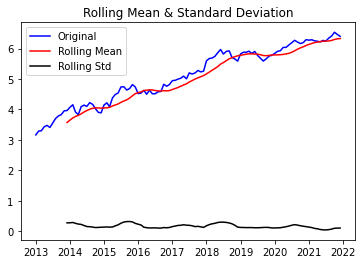

In [23]:
plot_rolling_statistics(ts_log)

In [24]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey_Fuller Test:
Test Statistic                  -1.618492
p-value                          0.473520
#Lags Used                       0.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


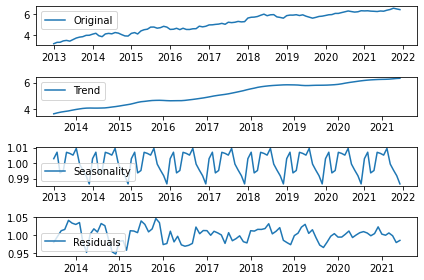

In [25]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

In [26]:
residual.dropna(inplace=True)

augmented_dickey_fuller_test(residual)

Results of Dickey_Fuller Test:
Test Statistic                 -4.810187
p-value                         0.000052
#Lags Used                     11.000000
Number of Observations Used    84.000000
Critical Value (1%)            -3.510712
Critical Value (5%)            -2.896616
Critical Value (10%)           -2.585482
dtype: float64


### Separate Dataset

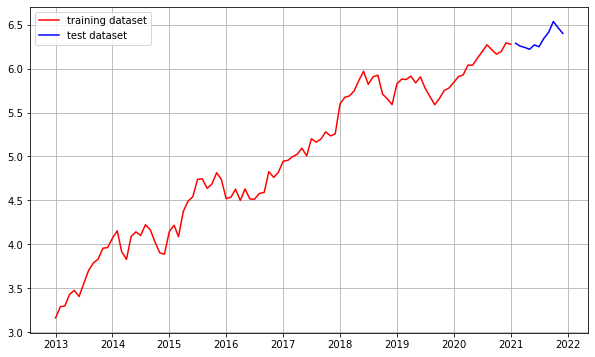

In [27]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### Set ARIMA Parameters

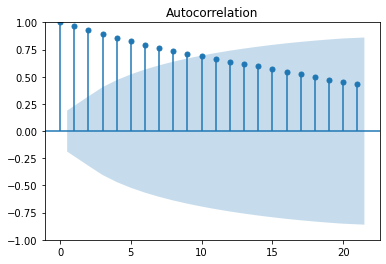

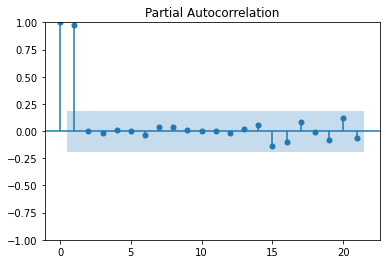

In [28]:
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

- `ACF` 는 점차적으로 감소하고 있고, `PACF` 는 `p` 가 2 이상일 때, 0 에 가까워지고 있습니다.
- 따라서, `p` 를 1 로 설정하도록 하겠습니다.

Results of Dickey_Fuller Test:
Test Statistic                -8.628302e+00
p-value                        5.848346e-14
#Lags Used                     1.000000e+00
Number of Observations Used    1.050000e+02
Critical Value (1%)           -3.494220e+00
Critical Value (5%)           -2.889485e+00
Critical Value (10%)          -2.581676e+00
dtype: float64
Results of Dickey_Fuller Test:
Test Statistic                -6.639311e+00
p-value                        5.460738e-09
#Lags Used                     5.000000e+00
Number of Observations Used    1.000000e+02
Critical Value (1%)           -3.497501e+00
Critical Value (5%)           -2.890906e+00
Critical Value (10%)          -2.582435e+00
dtype: float64


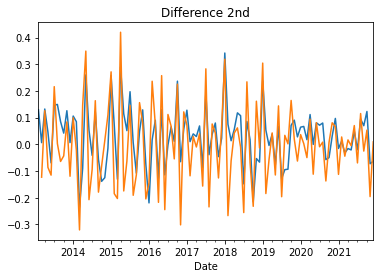

In [32]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

- 2 차 차분 후의 그래프가 안정성을 보이고 있습니다.

### Training & Forecasting

In [41]:
model = ARIMA(train_data, order=(1, 2, 0))
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   97
Model:                 ARIMA(1, 2, 0)   Log Likelihood                  50.192
Date:                Mon, 14 Feb 2022   AIC                            -96.385
Time:                        03:35:50   BIC                            -91.277
Sample:                    01-01-2013   HQIC                           -94.321
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4242      0.104     -4.084      0.000      -0.628      -0.221
sigma2         0.0203      0.003      7.069      0.000       0.015       0.026
Ljung-Box (L1) (Q):                   4.84   Jarque-

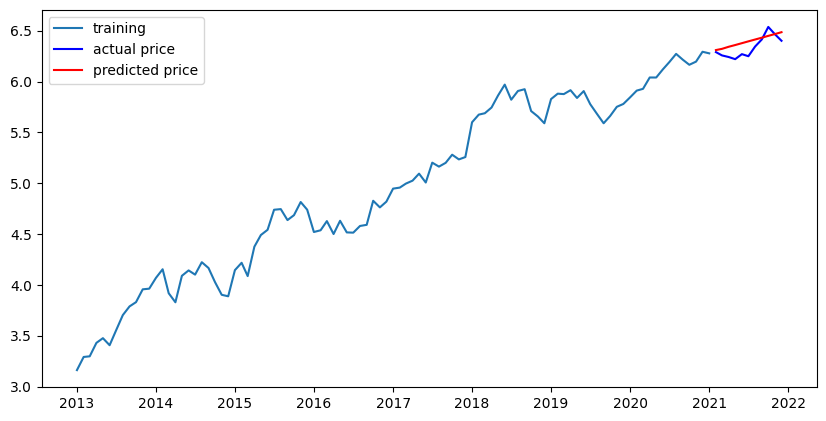

In [42]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

In [43]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  2557.900014994168
MAE:  43.75373423471767
RMSE:  50.575686006164744
MAPE: 7.98%


- `MAPE` 가 약 8 % 로 비교적 준수한 예측정확도가 도출되었습니다.

# Source Code 1.3)

- TSLA (Tesla Inc.) - (Jan 01, 2013 - Jan 01, 2022) Monthly Dataset

### Load Data

In [44]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/TSLA.csv'

df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2013-01-01     7.502
2013-02-01     6.966
2013-03-01     7.578
2013-04-01    10.798
2013-05-01    19.552
Name: Close, dtype: float64

### Data Preprocessing

In [45]:
ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [46]:
ts_log = np.log(ts)

### Stationary Analysis

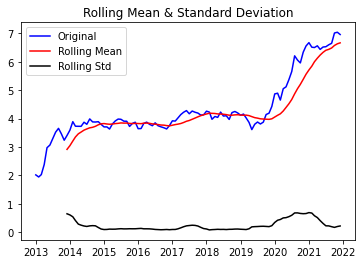

In [47]:
plot_rolling_statistics(ts_log)

In [48]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey_Fuller Test:
Test Statistic                   0.227693
p-value                          0.973773
#Lags Used                       4.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


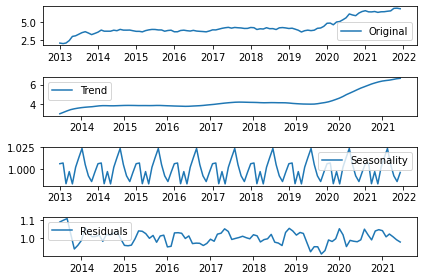

In [49]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

In [50]:
residual.dropna(inplace=True)

augmented_dickey_fuller_test(residual)

Results of Dickey_Fuller Test:
Test Statistic                 -4.858115
p-value                         0.000042
#Lags Used                      4.000000
Number of Observations Used    91.000000
Critical Value (1%)            -3.504343
Critical Value (5%)            -2.893866
Critical Value (10%)           -2.584015
dtype: float64


### Separate Dataset

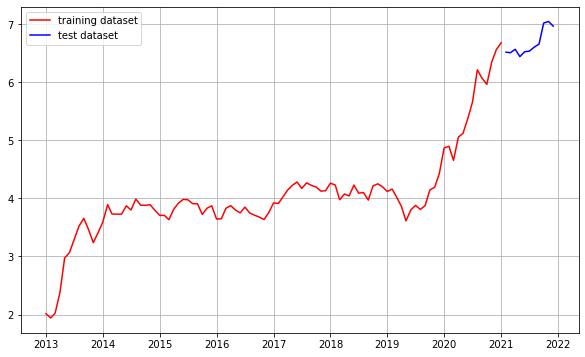

In [51]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### Set ARIMA Parameters

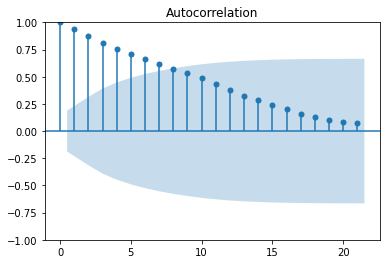

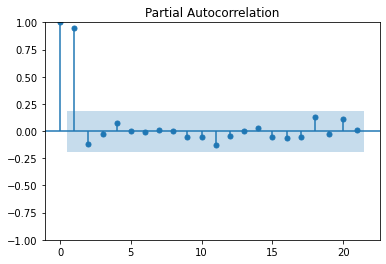

In [52]:
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

- `ACF` 는 점차적으로 감소하고 있고, `PACF` 는 `p` 가 2 이상일 때, 0 에 가까워지고 있습니다.
- 따라서, `p` 를 1 로 설정해주도록 하겠습니다.

Results of Dickey_Fuller Test:
Test Statistic                  -4.188218
p-value                          0.000690
#Lags Used                       3.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64
Results of Dickey_Fuller Test:
Test Statistic                -6.967269e+00
p-value                        8.848793e-10
#Lags Used                     5.000000e+00
Number of Observations Used    1.000000e+02
Critical Value (1%)           -3.497501e+00
Critical Value (5%)           -2.890906e+00
Critical Value (10%)          -2.582435e+00
dtype: float64


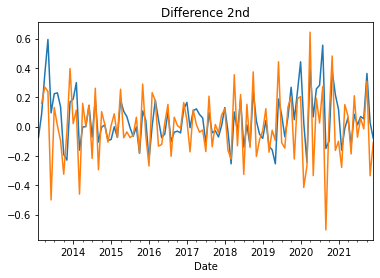

In [61]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# diff_3 = diff_2.diff(periods=1).iloc[1:]
# diff_3.plot(title='Difference 3rd')

# augmented_dickey_fuller_test(diff_3)

- 2 차 차분 후의 그래프가 안정성을 보이고 있습니다.

### Training & Forecasting

In [62]:
model = ARIMA(train_data, order=(1, 2, 0))
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   97
Model:                 ARIMA(1, 2, 0)   Log Likelihood                  17.312
Date:                Mon, 14 Feb 2022   AIC                            -30.624
Time:                        03:46:49   BIC                            -25.516
Sample:                    01-01-2013   HQIC                           -28.560
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3939      0.097     -4.046      0.000      -0.585      -0.203
sigma2         0.0406      0.005      7.465      0.000       0.030       0.051
Ljung-Box (L1) (Q):                   2.08   Jarque-

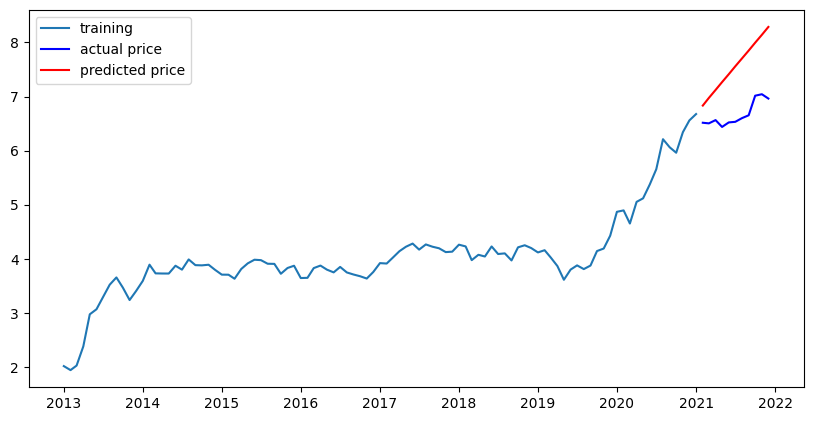

In [63]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

In [64]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  2383674.182037702
MAE:  1321.2221977199724
RMSE:  1543.9152120624053
MAPE: 154.46%


- `MAPE` 가 상당히 높게 도출되었습니다.
- `p` 와 `d` 값을 바꿔보며, 적절한 값을 찾아보겠습니다.

In [194]:
model = ARIMA(train_data, order=(1, 1, 0))
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   97
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  33.422
Date:                Mon, 14 Feb 2022   AIC                            -62.843
Time:                        03:55:13   BIC                            -57.714
Sample:                    01-01-2013   HQIC                           -60.770
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2183      0.084      2.602      0.009       0.054       0.383
sigma2         0.0292      0.004      7.661      0.000       0.022       0.037
Ljung-Box (L1) (Q):                   0.28   Jarque-

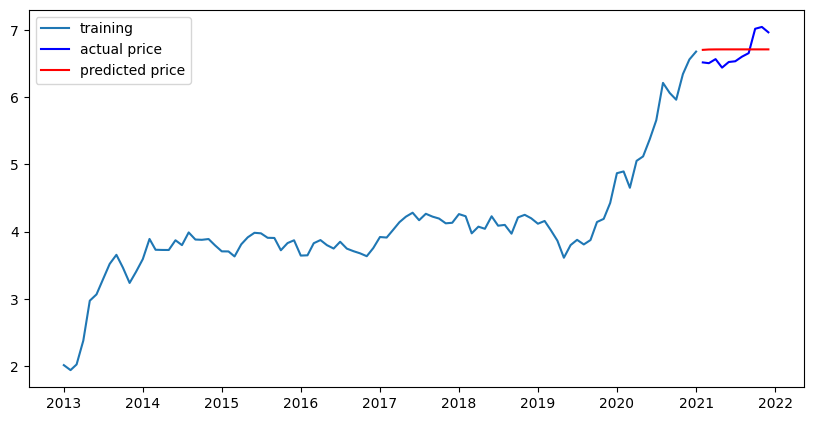

In [195]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

In [196]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  35127.38924698538
MAE:  168.33752287432424
RMSE:  187.4230221904059
MAPE: 20.37%


- 차분을 1, `p` 값을 1 로 설정하였을 때 가장 유사한 그래프가 도출되었습니다.
- 실제 주가 그래프가 불규칙한 양상을 띄고 있어 예측이 어려운 것으로 보입니다.

# Source Code 1.4)

- GOOG (Alphabet Inc.) - (Jan 01, 2013 - Jan 01, 2022) Monthly Dataset

### Load Data

In [197]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/GOOG.csv'

df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2013-01-01    376.434021
2013-02-01    399.104065
2013-03-01    395.612152
2013-04-01    410.745422
2013-05-01    433.983337
Name: Close, dtype: float64

### Data Preprocessing

In [198]:
ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [199]:
ts_log = np.log(ts)

### Stationary Analysis

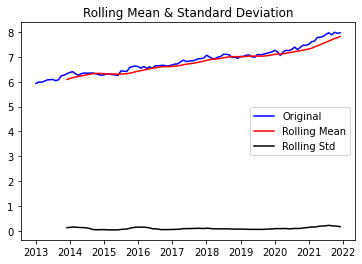

In [200]:
plot_rolling_statistics(ts_log)

In [201]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey_Fuller Test:
Test Statistic                   0.653658
p-value                          0.988866
#Lags Used                       2.000000
Number of Observations Used    105.000000
Critical Value (1%)             -3.494220
Critical Value (5%)             -2.889485
Critical Value (10%)            -2.581676
dtype: float64


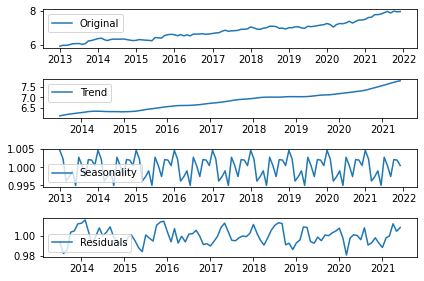

In [202]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

In [203]:
residual.dropna(inplace=True)

augmented_dickey_fuller_test(residual)

Results of Dickey_Fuller Test:
Test Statistic                 -4.672288
p-value                         0.000095
#Lags Used                     10.000000
Number of Observations Used    85.000000
Critical Value (1%)            -3.509736
Critical Value (5%)            -2.896195
Critical Value (10%)           -2.585258
dtype: float64


### Separate Dataset

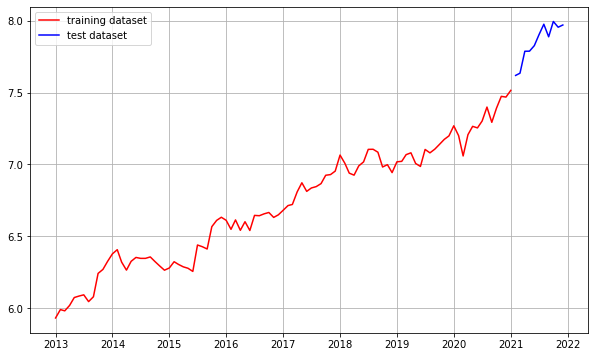

In [204]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### Set ARIMA Parameters

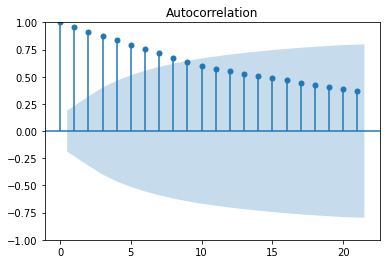

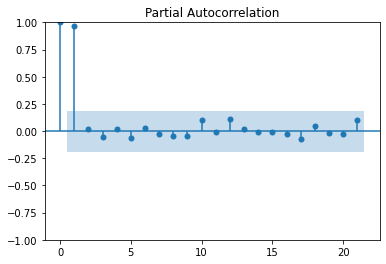

In [205]:
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

- `ACF` 는 점차적으로 감소하고 있고, `PACF` 는 `p` 가 2 이상일 때 0 에 가까워지고 있습니다.
- 따라서, `p` 값을 1 로 설정해주도록 하겠습니다.

Results of Dickey_Fuller Test:
Test Statistic                -1.191778e+01
p-value                        5.116346e-22
#Lags Used                     0.000000e+00
Number of Observations Used    1.060000e+02
Critical Value (1%)           -3.493602e+00
Critical Value (5%)           -2.889217e+00
Critical Value (10%)          -2.581533e+00
dtype: float64
Results of Dickey_Fuller Test:
Test Statistic                -7.280379e+00
p-value                        1.505849e-10
#Lags Used                     7.000000e+00
Number of Observations Used    9.800000e+01
Critical Value (1%)           -3.498910e+00
Critical Value (5%)           -2.891516e+00
Critical Value (10%)          -2.582760e+00
dtype: float64


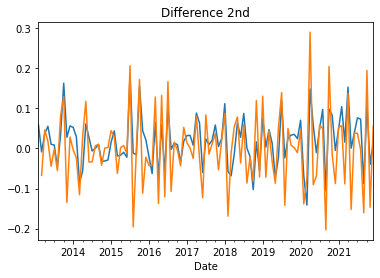

In [207]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

- 2 차 차분 이후의 그래프가 안정적으로 보입니다.

### Training & Forecasting

In [218]:
model = ARIMA(train_data, order=(1, 2, 0))
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   97
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 107.652
Date:                Mon, 14 Feb 2022   AIC                           -211.305
Time:                        04:50:05   BIC                           -206.197
Sample:                    01-01-2013   HQIC                          -209.241
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4821      0.092     -5.248      0.000      -0.662      -0.302
sigma2         0.0061      0.001      7.882      0.000       0.005       0.008
Ljung-Box (L1) (Q):                   4.56   Jarque-

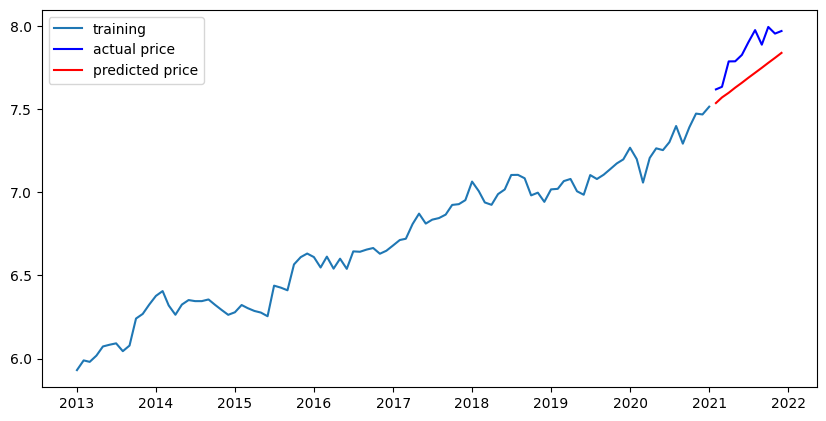

In [219]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

In [220]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  174532.72194557337
MAE:  389.6580170822101
RMSE:  417.7711358454212
MAPE: 14.68%


- `MAPE` 기준 약 14.7 % 의 결과가 도출되었습니다.

# Source Code 1.5)

- FB (Meta Platforms Inc.) - (Jan 01, 2013 - Jan 01, 2022) Monthly Dataset

### Load Data

In [221]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/FB.csv'

df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2013-01-01    30.98
2013-02-01    27.25
2013-03-01    25.58
2013-04-01    27.77
2013-05-01    24.35
Name: Close, dtype: float64

### Data Preprocessing

In [222]:
ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [223]:
ts_log = np.log(ts)

### Stationary Analysis

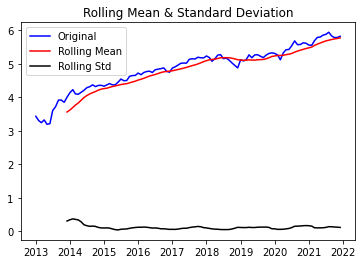

In [224]:
plot_rolling_statistics(ts_log)

In [225]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey_Fuller Test:
Test Statistic                  -2.515094
p-value                          0.111845
#Lags Used                       2.000000
Number of Observations Used    105.000000
Critical Value (1%)             -3.494220
Critical Value (5%)             -2.889485
Critical Value (10%)            -2.581676
dtype: float64


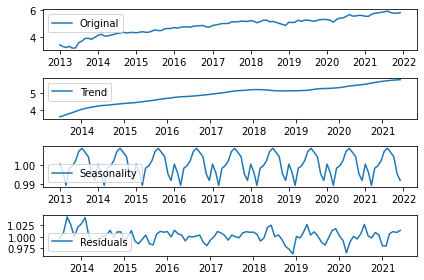

In [226]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

In [227]:
residual.dropna(inplace=True)

augmented_dickey_fuller_test(residual)

Results of Dickey_Fuller Test:
Test Statistic                 -4.807505
p-value                         0.000053
#Lags Used                      4.000000
Number of Observations Used    91.000000
Critical Value (1%)            -3.504343
Critical Value (5%)            -2.893866
Critical Value (10%)           -2.584015
dtype: float64


### Separate Dataset

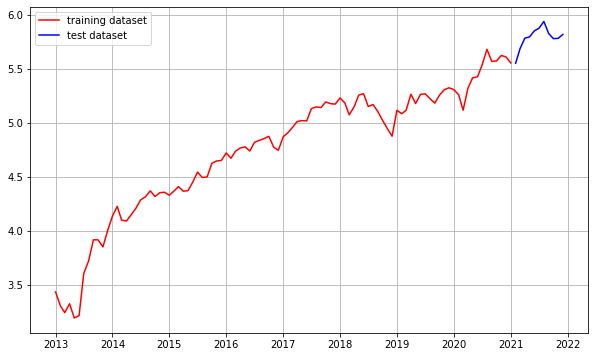

In [228]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### Set ARIMA Parameters

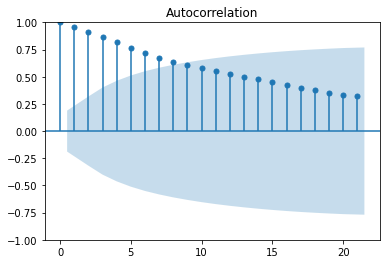

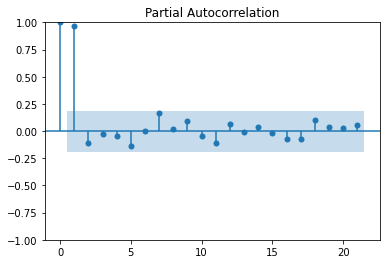

In [229]:
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

- `ACF` 는 점차적으로 감소하고 있고, `PACF` 는 `p` 가 2 이상일 때 0 에 가까워지고 있습니다.
- 따라서, `p` 값을 1 로 설정해주도록 하겠습니다.

Results of Dickey_Fuller Test:
Test Statistic                -8.628840e+00
p-value                        5.829823e-14
#Lags Used                     1.000000e+00
Number of Observations Used    1.050000e+02
Critical Value (1%)           -3.494220e+00
Critical Value (5%)           -2.889485e+00
Critical Value (10%)          -2.581676e+00
dtype: float64
Results of Dickey_Fuller Test:
Test Statistic                -6.134123e+00
p-value                        8.265647e-08
#Lags Used                     1.000000e+01
Number of Observations Used    9.500000e+01
Critical Value (1%)           -3.501137e+00
Critical Value (5%)           -2.892480e+00
Critical Value (10%)          -2.583275e+00
dtype: float64


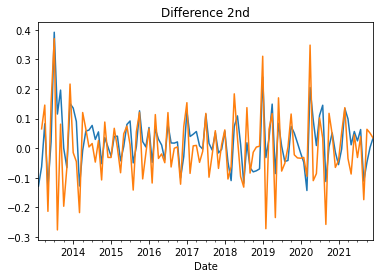

In [230]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

- 2 차 차분 이후의 그래프가 안정적으로 보입니다.

### Training & Forecasting

In [245]:
model = ARIMA(train_data, order=(1, 2, 0))
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   97
Model:                 ARIMA(1, 2, 0)   Log Likelihood                  75.054
Date:                Mon, 14 Feb 2022   AIC                           -146.108
Time:                        05:03:12   BIC                           -141.000
Sample:                    01-01-2013   HQIC                          -144.044
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3938      0.099     -3.958      0.000      -0.589      -0.199
sigma2         0.0120      0.001      9.646      0.000       0.010       0.014
Ljung-Box (L1) (Q):                   3.43   Jarque-

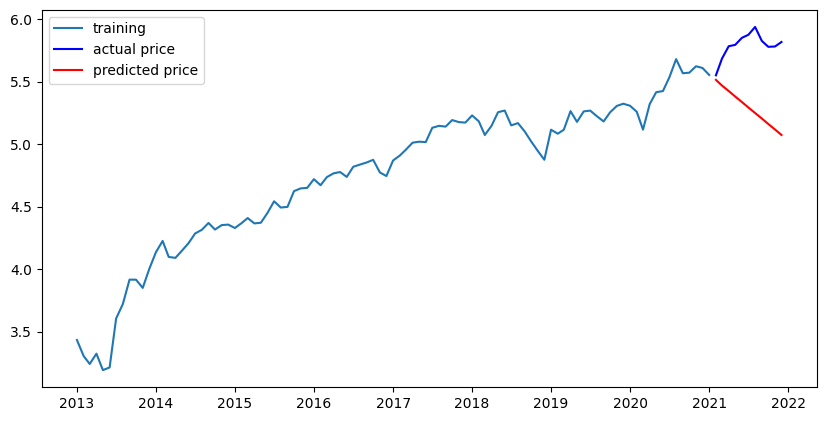

In [246]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

In [247]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  18915.085267502516
MAE:  127.41366853555314
RMSE:  137.53212449279812
MAPE: 37.68%


- 이전 경향을 반영하여 아래로 떨어지는 그래프의 형태가 도출되었습니다.
- `p` 와 `d` 값을 변경하며 적절한 값을 찾아보도록 하겠습니다.

In [321]:
model = ARIMA(train_data, order=(9, 2, 0))
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   97
Model:                 ARIMA(9, 2, 0)   Log Likelihood                  97.675
Date:                Mon, 14 Feb 2022   AIC                           -175.351
Time:                        05:07:42   BIC                           -149.812
Sample:                    01-01-2013   HQIC                          -165.031
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8297      0.115     -7.192      0.000      -1.056      -0.604
ar.L2         -0.9168      0.127     -7.214      0.000      -1.166      -0.668
ar.L3         -0.6890      0.148     -4.652      0.0

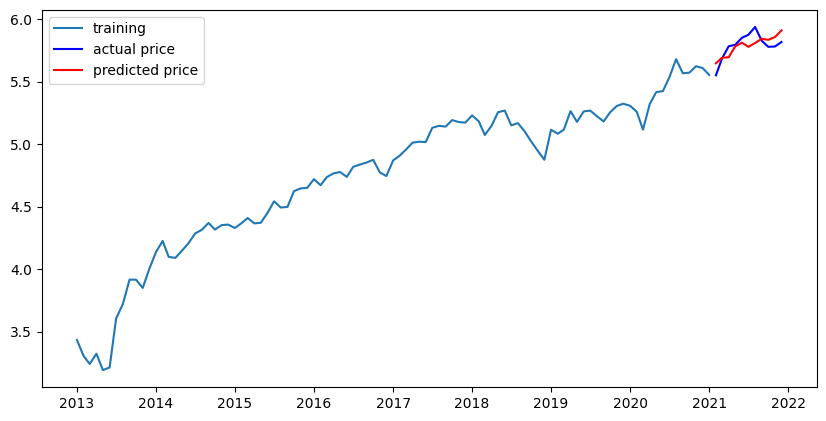

In [322]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

In [323]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  625.7632780517972
MAE:  21.231494727120616
RMSE:  25.015260903132656
MAPE: 6.40%


- `p` 값이 9 이고 `d` 값이 2 일 때 약 6.4 % 의 `MAPE` 가 도출되었습니다.

# Retrospection

<h2 style="font-style:italic">2022.02.14 - [E-11]StockPrediction</h2>

> 이번에는 주식 종가 데이터의 변화를 바탕으로 각 기업별 주가 변동을 예측해보는 프로젝트를 진행하였습니다. 아래에서는 프로젝트 진행 중 어려웠던 점이나 알게된 점, 모호한 점에 대해 회고해보도록 하겠습니다.

***

**어려웠던 점**
<br>
<br>
- ADF Test 와 ACF, PACF 그래프와 같은 다양한 통계적인 개념들이 어렵게 느껴졌습니다. 
<br>
<br>
- 도출된 ACF 그래프, PACF 그래프와 P-Value 의 관계가 어려웠습니다.
<br>
<br>
- 차분에 대한 개념도 명확하게 이해되지 않았습니다. Trend 로 포착되지 않고 패턴이 아직 파악되지 않은 주기적인 변화를 상쇄시켜 각 스텝별로 발생한 변화량에 대해서 측정한다는 의미로 이해하였지만, 차분을 누적하는 원리에 대해서는 아직 어렵습니다.
<br>
<br>
- AR 모델과 MA 모델이 각각 Residual, Trend 에 해당하는 부분을 모델링 하는 것이라는 말이 이해가 어려웠습니다. AR 모델은 주가가 항상 일정한 균형 수준을 유지할 것이라고 예측하는 관점이고, MA 모델은 최근의 증감 패턴을 지속할 것이라고 예측하는 관점입니다. 하지만, ARIMA 모델에서 각각의 모델이 p, d, q 를 통해 어떻게 균형을 맞춰갈 수 있는지에 대한 내용이 잘 이해가 되지 않았습니다.

**알게된 점**
<br>
<br>
- 시계열 데이터에 대해서 높은 성능으로 예측을 하기 위해서는 시계열 데이터가 안정적이어야 한다는 것에 대해 알게되었습니다. 또한, 안정적이라는 것은 각 데이터의 평균, 분산, 공분산이 시간의 추이와 관계없이 일정하다는 것을 의미합니다. 즉, 모든 시계열 데이터에 대해 유의미한 예측 결과를 만들어내는 것은 불가능하고 안정적인 시계열 데이터에 대한 예측을 위해 다양한 전처리 과정 및 Decomposition 을 거치게 되는 것입니다.
<br>
<br>
- 공분산이 X, Y 두 변수의 분포가 얼마나 상관성을 가지는지를 나타내는 지표라는 점에 대해 알게되었습니다. 이전까지는 상관성의 지표로는 상관계수만이 존재한다고 생각해왔는데, 공분산 또한 두 변수 간 상관성을 나타내는 개념으로 사용될 수 있었습니다. 단, 공분산은 단위의 크기에 영향을 크게 받으므로 값 자체가 유의미하다고 볼 수는 없지만, 상관계수는 이러한 공분산의 단점을 해결해 줄 수 있습니다.
<br>
<br>
- 시계열 데이터에 있어서는 자기 자신을 h 만큼 이동시킨 값에 대해 공분산을 구해낼 수 있다는 점에 대해 알게 되었습니다. 시간의 추이가 시계열 데이터에 있어 중요한 환경인만큼 자기 자신을 이동시킨 변수와 자기 자신의 상관성을 분석해내는 일은 향후 데이터 예측에 중요한 지표로 사용될 수 있을 것 같습니다. 이는 자기공분산이라고 부릅니다.
<br>
<br>
- 귀무가설과 대립가설, P-Value 에 대해서 알게 되었습니다. 귀무가설은 처음부터 버릴 것을 예상하고 설정하는 가설입니다. 즉, 차이가 없거나 의미있는 차이가 없는 경우의 가설로서 통계학적인 증명을 통해 이를 기각시키는 것이 목적입니다. 반대로 대립가설은 귀무가설이 기각될 경우에 참이되는 가설입니다. 즉, 유의미한 차이가 존재하거나 효과가 있음을 가정하는 가설입니다. P-Value 는 귀무가설이 참이라고 가정했을 때, 표본으로부터 얻어지는 통계치가 나타날 확률입니다. 관례적으로 0.5 로 사용되며 만약 0.5 보다 낮다면 귀무가설이 참일 때 표본을 추출하였을 경우, 이러한 표본 평균이 측정될 확률이 낮다는 것을 의미합니다. 따라서 귀무가설이 기각되고 대립가설이 채택되는 것입니다.

**모호한 점**
<br>
<br>
- 프로젝트 안에서 사용된 다양한 통계적, 수학적 개념들에 대한 개인적인 학습이 필요할 것 같습니다.
<br>
<br>
- ACF, PACF 그래프에 대해 학습하고, AR 모델, MA 모델에 대한 이해가 필요할 것 같습니다.
<br>
<br>
- 시계열 데이터에서 Trend 와 Seasonality 를 제거한 Residual 데이터를 사용하여 예측을 수행하였는데, 이렇게 각각의 변화량만을 추출해낸다고 하더라도, 데이터를 인위적으로 조작하는 것이기 때문에 손실이 있을 것으로 생각됩니다. 이러한 손실된 데이터에 대한 부분은 제거하고 예측을 수행해도 되는 것인지 궁금합니다.
<br>
<br>
- 또한, Trend 와 Seasonality 를 제거한 Residual 데이터에 대해 예측을 수행하는 것이 정확하게 원본 데이터에 대해 예측을 수행하는 것이라고 생각되지 않는데, 이런 방법을 사용해서 예측을 하는 것이 과연 가능한 방법인지에 대해 의문이 들었습니다.